In [4]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
from models import make_model
import porepy as pp

# Grid refinement

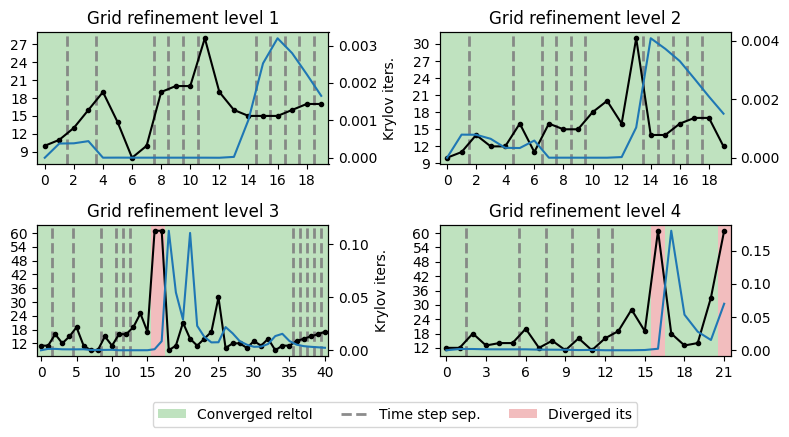

In [7]:
grid_refinement = [1, 2, 3, 4]
geo = 3
ph = 1
bb = 2
fr = 1
sol = 2

data = {}
names = {}
for i, g in enumerate(grid_refinement):
    data[i] = load_data(f"../stats/stats_geo{geo}x{g}_sol{sol}_ph{ph}_bb{bb}_fr{fr}.json")
    names[i] = f"Grid refinement level {g}"


shape = [2, 2]
figsize = (8, 4)


def render_element(entry: list[TimeStepStats]):
    color_converged_reason(entry)
    # color_sticking_sliding_open(entry)

    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    set_integer_ticks("vertical")
    plt.plot(get_gmres_iterations(entry), marker=".", color="black")

    coulomb_mismatch = [ls.coulomb_mismatch for ts in entry for ls in ts.linear_solves]
    sticking_ut = [ls.sticking_u_mismatch for ts in entry for ls in ts.linear_solves]
    lambdan_max = [ls.lambdan_max for ts in entry for ls in ts.linear_solves]
    lambdan_max[0] = 0
    lambdat_max = [ls.lambdat_max for ts in entry for ls in ts.linear_solves]
    ujumpn_max = [ls.un_max for ts in entry for ls in ts.linear_solves]
    ujumpt_max = [ls.ut_max for ts in entry for ls in ts.linear_solves]

    plt.gca().twinx()
    # plt.yscale('log')
    # plt.plot(coulomb_mismatch, label='Coulomb mismatch')  # interesting
    # plt.plot(sticking_ut, label=r"Sticking $u_\tau$ mismatch")  # interesting
    plt.plot(lambdan_max, label=r'$\lambda_n$ max')
    # plt.plot(lambdat_max, label=r'$\lambda_\tau$ max')
    # plt.plot(ujumpn_max, label=r"$u_n$ max")
    # plt.plot(ujumpt_max, label=r'$u_\tau$ max')
    # plt.ylim(bottom=1e-6)


plot_grid(
    data, render_element, shape=shape, figsize=figsize, legend=True, ax_titles=names
)

In [6]:
import pandas as pd


gmres_iters = []
avg_newton_iters = []
max_newton_iters = []
refinement_levels = []
dofs = []
for g in grid_refinement:
    stats_name = f"stats_geo{geo}x{g}_sol{sol}_ph{ph}_bb{bb}_fr{fr}.json"
    entry = load_data(f"../stats/{stats_name}")
    try:
        dofs_info = load_data(f"../stats/dofs_info_{stats_name}")
        total_dofs = (
            dofs_info["block 0"]
            + dofs_info["block 1"]
            + dofs_info["block 2"]
            + dofs_info["block 3"]
            + dofs_info["block 4"]
            + dofs_info["block 5"]
        )
        dofs.append(total_dofs)
    except FileNotFoundError:
        dofs.append(-1)
    num_gmres = get_gmres_iterations(entry)
    gmres_iters.append(round(np.mean(num_gmres)))
    newton_iter = get_newton_iterations(entry)
    avg_newton_iters.append(round(np.mean(newton_iter)))
    max_newton_iters.append(round(max(newton_iter)))
    refinement_levels.append(f"x{g}")


table = pd.DataFrame(
    [
        refinement_levels,
        dofs,
        gmres_iters,
        avg_newton_iters,
        max_newton_iters,
    ],
    index=[
        "Refinement level",
        "Total DoFs",
        "Avg. GMRES iter.",
        "Avg. Newton iter.",
        "Max. Newton iter.",
    ],
)
table

,0,1,2,3
Refinement level,x1,x2,x3,x4
Total DoFs,23504,157620,509908,-1
Avg. GMRES iter.,16,15,16,20
Avg. Newton iter.,2,2,3,3
Max. Newton iter.,4,4,23,9
